In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import numpy as np

import hiive.mdptoolbox.mdp as mdp
import hiive.mdptoolbox.example as example

In [2]:
# helper function to plot curves
def make_plot(x_values, y_values_dict, x_label, y_label):
    
    fig = plt.figure()
    ax = plt.gca()
    for key in y_values_dict.keys():
        ax.plot(x_values, y_values_dict[key], label=key)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = '{} as a function of {}'.format(y_label, x_label)
    ax.set_title(title)
    ax.legend()

## Set problem parameters

In [3]:
dims = (40, 40)
state = dims[0] * dims[1]
r1 = 4
r2 = 2
p = 0.1
gamma = 0.99
max_iter = 10000

action_mapping = {0: 'w', 1: 'c'}

In [4]:
P, R = example.forest(S=state, r1=r1, r2=r2, p=p, is_sparse=False)

## Policy Iteration

In [5]:
pi = mdp.PolicyIteration(P, R, gamma=gamma, max_iter=max_iter)
pi_result = pi.run()

In [6]:
pi_iters = [iteration['Iteration'] for iteration in pi_result]
pi_errors = [iteration['Error'] for iteration in pi_result]
pi_times = [iteration['Time'] for iteration in pi_result]
pi_rewards = [iteration['Mean V'] for iteration in pi_result]

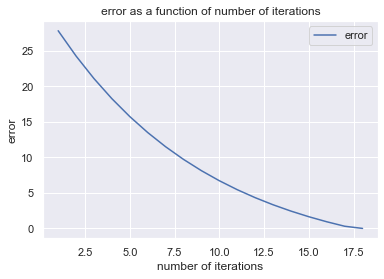

In [7]:
make_plot(pi_iters, {'error': pi_errors}, 'number of iterations', 'error')

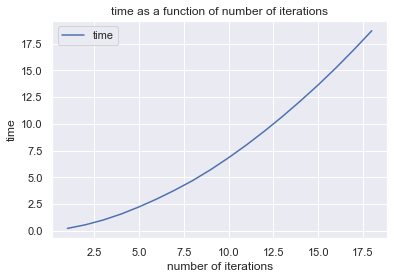

In [8]:
make_plot(pi_iters, {'time': np.cumsum(pi_times)}, 'number of iterations', 'time')

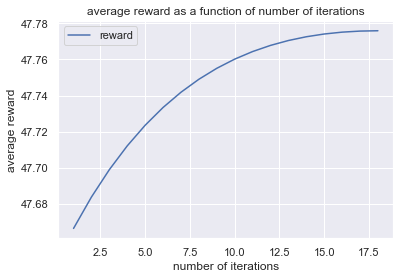

In [9]:
make_plot(pi_iters, {'reward': pi_rewards}, 'number of iterations', 'average reward')

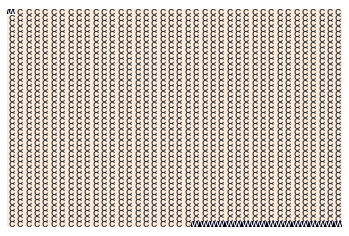

In [10]:
sns.heatmap(np.array(pi.policy).reshape(dims), 
            annot=np.array(list(map(lambda x: action_mapping[x], pi.policy))).reshape(dims), 
            fmt='',  
            xticklabels='', 
            yticklabels='',
            cbar=False);

## Value Iteration

In [11]:
vi = mdp.ValueIteration(P, R, gamma=gamma, max_iter=max_iter)
vi_result = vi.run()

In [12]:
vi_iters = [iteration['Iteration'] for iteration in vi_result]
vi_errors = [iteration['Error'] for iteration in vi_result]
vi_times = [iteration['Time'] for iteration in vi_result]
vi_rewards = [iteration['Mean V'] for iteration in vi_result]

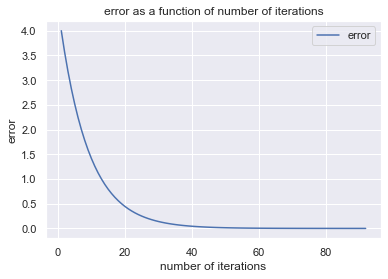

In [13]:
make_plot(vi_iters, {'error': vi_errors}, 'number of iterations', 'error')

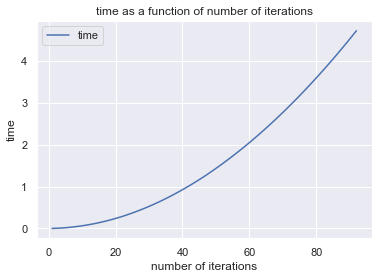

In [14]:
make_plot(vi_iters, {'time': np.cumsum(vi_times)}, 'number of iterations', 'time')

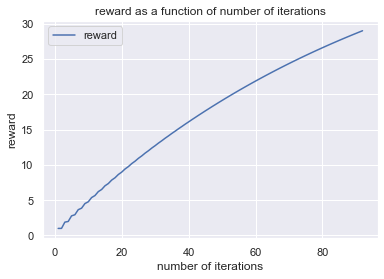

In [15]:
make_plot(vi_iters, {'reward': vi_rewards}, 'number of iterations', 'reward')

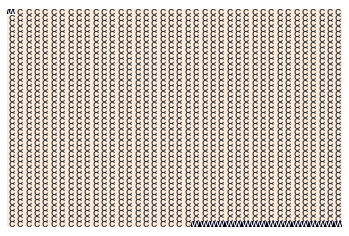

In [16]:
sns.heatmap(np.array(vi.policy).reshape(dims), 
            annot=np.array(list(map(lambda x: action_mapping[x], vi.policy))).reshape(dims), 
            fmt='',  
            xticklabels='', 
            yticklabels='',
            cbar=False);

## Q-learning

In [17]:
epsilon_range = [0.1, 0.9, 0.99]
alpha_range = [0.3, 0.6, 0.9]
alpha_decay = 0.2
epsilon_decay = 0.999999

In [18]:
%%time
results = {}

for epsilon in epsilon_range:
    for alpha in alpha_range:
        ql = mdp.QLearning(P, R, gamma=gamma, 
                           alpha=alpha, 
                           alpha_decay=alpha_decay,
                           epsilon=epsilon, 
                           epsilon_decay=epsilon_decay,
                           n_iter=max_iter)
        ql_result = ql.run()
        
        temp = {}
        temp['ql_iters'] = [iteration['Iteration'] for iteration in ql_result]
        temp['ql_errors'] = [iteration['Error'] for iteration in ql_result]
        temp['ql_times'] = [iteration['Time'] for iteration in ql_result]
        
        results[(epsilon, alpha)] = temp

CPU times: user 6.62 s, sys: 56.9 ms, total: 6.68 s
Wall time: 6.83 s


In [19]:
error_data = {}
for epsilon, alpha in results.keys():
    error_data['error; eps: {} lr: {}'.format(epsilon, alpha)] = results[(epsilon, alpha)]['ql_errors']

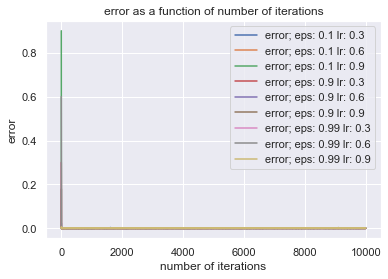

In [20]:
make_plot(list(range(0,max_iter)), error_data, 'number of iterations', 'error')

In [21]:
error_data_reduced = {}
cutoff = 10
for epsilon, alpha in results.keys():
    error_data_reduced['error; eps: {}, lr: {}'.format(epsilon, alpha)] \
        = results[(epsilon, alpha)]['ql_errors'][:cutoff]

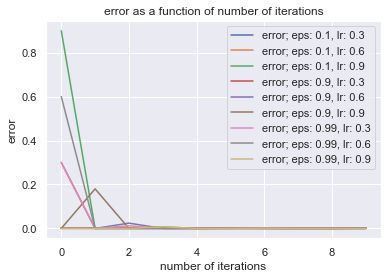

In [22]:
make_plot(list(range(0,max_iter))[:cutoff], error_data_reduced, 'number of iterations', 'error')

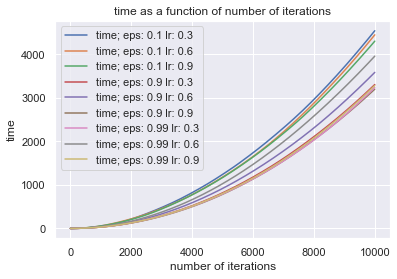

In [23]:
time_data = {}
for epsilon, alpha in results.keys():
    time_data['time; eps: {} lr: {}'.format(epsilon, alpha)] = np.cumsum(results[(epsilon, alpha)]['ql_times'])
make_plot(list(range(0,max_iter)), time_data, 'number of iterations', 'time')

In [24]:
ql = mdp.QLearning(P, R, gamma=gamma, 
                   alpha=0.3, 
                   alpha_decay=alpha_decay,
                   epsilon=0.99, 
                   epsilon_decay=epsilon_decay,
                   n_iter=max_iter)
ql_result = ql.run()

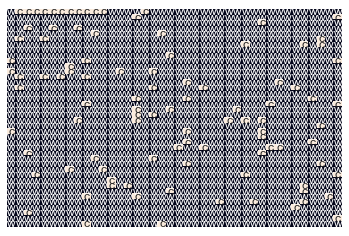

In [25]:
sns.heatmap(np.array(ql.policy).reshape(dims), 
            annot=np.array(list(map(lambda x: action_mapping[x], ql.policy))).reshape(dims), 
            fmt='',  
            xticklabels='', 
            yticklabels='',
            cbar=False);